In [1]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.9 MB/s eta 0:00:00:00:01


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [3]:
data_path = "/kaggle/input/ljspeech-sr16k-dataset" 

In [4]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [5]:
metadata_df = pd.read_csv(metadata_path)

In [6]:
metadata_df.head()

,Unnamed: 0,id,sentence,file_name,audio_path
0,0,LJ001-0001,"Printing, in the only sense with which we are ...",LJ001-0001.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
1,1,LJ001-0002,in being comparatively modern.,LJ001-0002.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
2,2,LJ001-0003,For although the Chinese took impressions from...,LJ001-0003.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
3,3,LJ001-0004,"produced the block books, which were the immed...",LJ001-0004.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
4,4,LJ001-0005,the invention of movable metal letters in the ...,LJ001-0005.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...


In [7]:
metadata_df = metadata_df.drop(columns=['Unnamed: 0'],axis=1)

In [8]:
metadata_df.head()

,id,sentence,file_name,audio_path
0,LJ001-0001,"Printing, in the only sense with which we are ...",LJ001-0001.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
1,LJ001-0002,in being comparatively modern.,LJ001-0002.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
2,LJ001-0003,For although the Chinese took impressions from...,LJ001-0003.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
3,LJ001-0004,"produced the block books, which were the immed...",LJ001-0004.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...
4,LJ001-0005,the invention of movable metal letters in the ...,LJ001-0005.wav,/kaggle/input/ljspeech-dataset/LJSpeech-1.1/wa...


In [9]:
metadata_df = metadata_df[["file_name","sentence"]]

metadata_df.head()

,file_name,sentence
0,LJ001-0001.wav,"Printing, in the only sense with which we are ..."
1,LJ001-0002.wav,in being comparatively modern.
2,LJ001-0003.wav,For although the Chinese took impressions from...
3,LJ001-0004.wav,"produced the block books, which were the immed..."
4,LJ001-0005.wav,the invention of movable metal letters in the ...


In [10]:
split = int(len(metadata_df)*0.8)

df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(len(df_train))
print(len(df_val))

10480
2620


In [11]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = tf.keras.layers.StringLookup(vocabulary=characters,oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),oov_token="",invert=True
)

print(char_to_num.get_vocabulary())
print(char_to_num.vocabulary_size())

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
31


In [14]:
char_to_num('a')

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [19]:
frame_length = 256

frame_step = 160

fft_length = 384

def encode_single_sample(wav_file,label):
    
    file = tf.io.read_file(wavs_path + wav_file)
    
    audio,_ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio,axis=-1)
    
    audio = tf.cast(audio,tf.float32)
    
    spectogram = tf.signal.stft(
        audio,frame_length=frame_length, frame_step=frame_step,fft_length=fft_length
    )
    
    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram,0.5)
    
    means = tf.math.reduce_mean(spectogram,1,keepdims=True)
    stddevs = tf.math.reduce_std(spectogram,1,keepdims=True)
    spectogram = (spectogram - means)/(stddevs + 1e-10)
    
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label,input_encoding="UTF-8")
    
    label = char_to_num(label)
    
    return spectogram,label
    

In [20]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["sentence"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["sentence"]))
)

val_dataset = (
    val_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


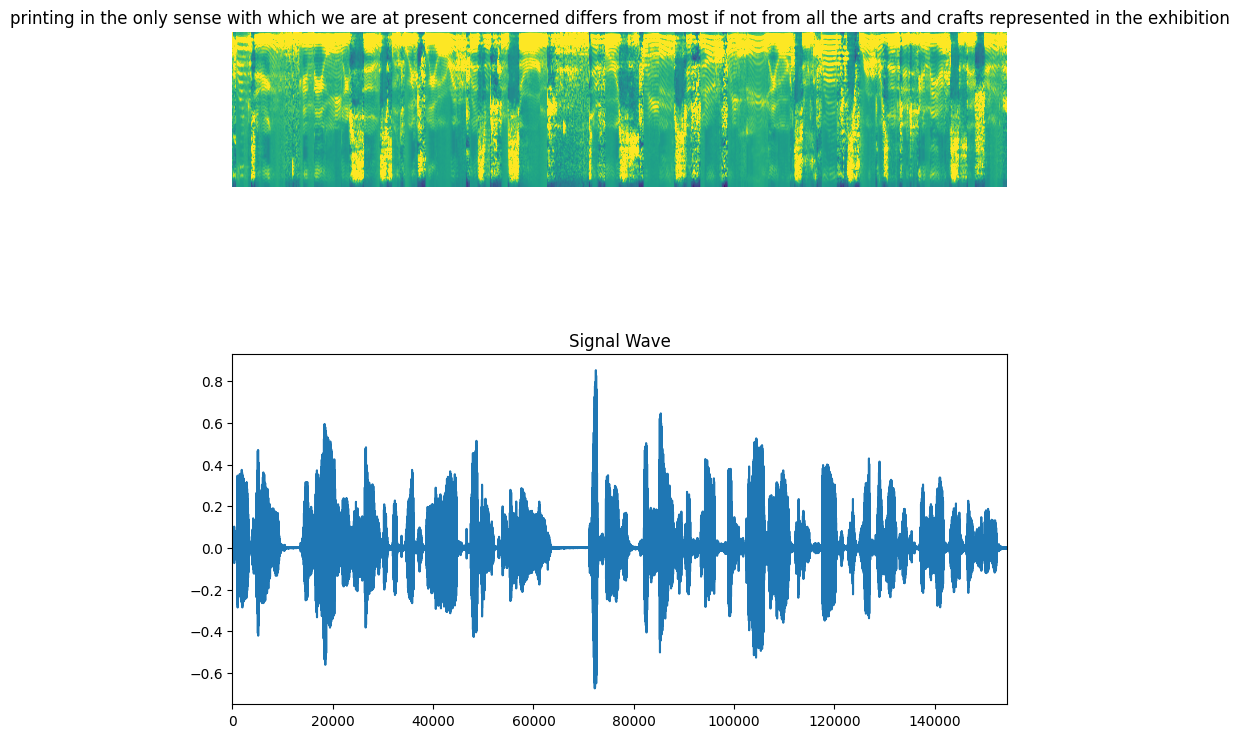

In [22]:
fig = plt.figure(figsize=(10,10))

for batch in train_dataset.take(1):
    spectogram = batch[0][0].numpy()
    spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
    
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2,1,1)
    ax.imshow(spectogram,vmax=1)
    ax.set_title(label)
    ax.axis("off")
    
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0])
    audio,_ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2,1,2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0,len(audio))
    display.display(display.Audio(np.transpose(audio),rate = 16000))
    
plt.show()
    

In [23]:
def CTCLoss(y_true,y_pred):
    
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_len = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_len = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_len = input_len * tf.ones(shape=(batch_len,1), dtype="int64")
    label_len = label_len * tf.ones(shape=(batch_len,1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_len,label_len)
    
    return loss

In [26]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectogram = layers.Input(shape=(None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)
    
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        padding="same",
        use_bias=False,
        name="conv_1"
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="pool_1")(x)  # Add pooling layer

    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        padding="same",
        use_bias=False,
        name="conv_2"
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.MaxPooling2D(pool_size=(1, 2), name="pool_2")(x)  # Add pooling layer

    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
        )
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    model = tf.keras.Model(input_spectogram, output, name="Speech_Model")

    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)

    return model

In [27]:
model = build_model(input_dim = fft_length//2 + 1, output_dim = char_to_num.vocabulary_size(),rnn_units=512)

model.summary(line_length= 512)

Model: "Speech_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                                                                                     
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input (InputLayer)                                                                                               
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ expand_dim (Reshape)                                                                                             
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ conv_1 (Conv2D)                                                                                                  
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ conv_1_bn (BatchNormalization)                                                                                   
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ conv_1_relu (ReLU)                                                                                               
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ pool_1 (MaxPooling2D)                                                                                            
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ conv_2 (Conv2D)                                                                                                  
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ conv_2_bn (BatchNormalization)                                                                                   
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ conv_2_relu (ReLU)                                                                                               
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ pool_2 (MaxPooling2D)                                                                                            
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ reshape (Reshape)                                                                                                
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ bidirectional_1 (Bidirectional)                                                                                  
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ dropout (Dropout)                                                                                                
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ bidirectional_2 (Bidirectional)                                                                                  
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ dropout_1 (Dropout)                                                                                              
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
│ bidirectional_3 (Bidirectional)                                                                                  
├───────────────────────────────────────────────────────

 Total params: 26,530,176 (101.20 MB)

 Trainable params: 26,530,048 (101.20 MB)

 Non-trainable params: 128 (512.00 B)

In [28]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    results = tf.keras.backend.ctc_decode(pred,input_length = input_len, greedy=True)[0][0]
    
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
        
        return output_text

In [ ]:
epochs = 20

history = model.fit(train_dataset, validation_data = val_dataset, epochs = epochs)